# Lecture 3. Ensemble Learning


In [1]:
# Global imports and settings
%matplotlib inline
from preamble import *
plt.rcParams['figure.dpi'] = 100 # Use 300 for PDF, 100 for slides
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides
from sklearn.ensemble import RandomForestClassifier  
from sklearn.datasets import make_moons
from sklearn.model_selection import ShuffleSplit, train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from matplotlib.colors import ListedColormap
from sklearn.tree import DecisionTreeClassifier
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from sklearn.preprocessing import normalize
import mglearn.plot_classifiers as pc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Ensemble learning
Ensembles are methods that combine multiple machine learning models (weak learners) to create more powerful models. Most popular are:

* __Bagging__: Reduce variance: Build many trees on random samples and do a vote over the predictions 
    * __RandomForests__: Build randomized trees on random bootstraps of the data
* __Boosting__: Reduce bias: Build trees iteratively, each correcting the mistakes of the previous trees
    * __Adaboost__: Ensemble of weighted trees, increasing importance of misclassified points
    * __Gradient boosting machines__: Gradually update importance of hard points until ensemble is correct
    * __XGBoost__: Faster implemenation of gradient boosting machines
* __Stacking__: Build group of base models, and train a meta-model to learn how to combine the base model predicions

### Bagging (Bootstrap Aggregating)
Reduce overfitting by averaging out individual predictions (variance reduction)

* Take a _bootstrap sample_ of your data
    * Randomly sample with replacement
    * Build a tree on each bootstrap
* Repeat `n_estimators` times 
    * Higher values: more trees, more smoothing
    * Make prediction by aggreting the individual tree predictions
* Can be done with any model (but usually trees)
    * Since Bagging only reduces variance (not bias), it makes sense to use models that are high variance, low bias
* RandomForest: Randomize trees by considering only a random subset of features of size `max_features` _in each node_
    * Higher variance, lower bias than normal trees
    * Small `max_features` yields more different trees, more smoothing
    * Default: $sqrt(n\_features)$ for classification, $log2(n\_features)$ for regression


## Effect on bias and variance

* Increasing the number of estimators decreases variance
* Bias is mostly unaffected, but will increase if the forest becomes too large (oversmoothing)

In [13]:
# Bias-Variance Computation 
def compute_bias_variance(clf, X, y):
    # Bootstraps
    n_repeat = 40 # 40 is on the low side to get a good estimate. 100 is better.
    shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat, random_state=0)

    # Store sample predictions
    y_all_pred = [[] for _ in range(len(y))]

    # Train classifier on each bootstrap and score predictions
    for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
        # Train and predict
        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])

        # Store predictions
        for j,index in enumerate(test_index):
            y_all_pred[index].append(y_pred[j])

    # Compute bias, variance, error
    bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])
    error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat for i,x in enumerate(y_all_pred)])

    return np.sqrt(bias_sq), var, error

In [14]:
# example data
cancer = load_breast_cancer()
cancer.data[:2]

array([[  17.99 ,   10.38 ,  122.8  , 1001.   ,    0.118,    0.278,
           0.3  ,    0.147,    0.242,    0.079,    1.095,    0.905,
           8.589,  153.4  ,    0.006,    0.049,    0.054,    0.016,
           0.03 ,    0.006,   25.38 ,   17.33 ,  184.6  , 2019.   ,
           0.162,    0.666,    0.712,    0.265,    0.46 ,    0.119],
       [  20.57 ,   17.77 ,  132.9  , 1326.   ,    0.085,    0.079,
           0.087,    0.07 ,    0.181,    0.057,    0.543,    0.734,
           3.398,   74.08 ,    0.005,    0.013,    0.019,    0.013,
           0.014,    0.004,   24.99 ,   23.41 ,  158.8  , 1956.   ,
           0.124,    0.187,    0.242,    0.186,    0.275,    0.089]])

In [15]:
cancer.target[:2]

array([0, 0])

In [16]:
def plot_bias_variance_rf(clf, X, y):
    bias_scores = []
    var_scores = []
    err_scores = []
    n_estimators= [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    for i in n_estimators:
        b,v,e = compute_bias_variance(clf.set_params(random_state=0,n_estimators=i),X,y)
        bias_scores.append(b)
        var_scores.append(v)
        err_scores.append(e)

    plt.figure(figsize=(5,2))
    plt.rcParams.update({'font.size': 12})
    plt.suptitle(clf.__class__.__name__)
    plt.plot(n_estimators, var_scores,label ="variance" )
    plt.plot(n_estimators, np.square(bias_scores),label ="bias^2")
    plt.plot(n_estimators, err_scores,label ="error" )
    plt.xscale('log',basex=2)
    plt.xlabel("n_estimators")
    plt.legend(loc="best")
    plt.show()

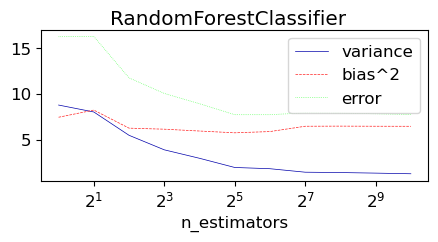

In [17]:
X, y = cancer.data, cancer.target
rf = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
plot_bias_variance_rf(rf, X, y)

Scikit-learn algorithms:

- `RandomForestClassifier` (or Regressor)
- `ExtraTreesClassifier`: Grows deeper trees, faster

Most important parameters:

* `n_estimators` (higher is better, but diminishing returns)
    * Will start to underfit (bias error component increases slightly)
* `max_features` (default is typically ok)
    * Set smaller to reduce space/time requirements
* parameters of trees, e.g. `max_depth` (less effect)

`n_jobs` sets the number of parallel cores to run  
`random_state` should be fixed for reproducibility

#### Feature importance
RandomForests provide more reliable feature importances, based on many alternative hypotheses (trees)

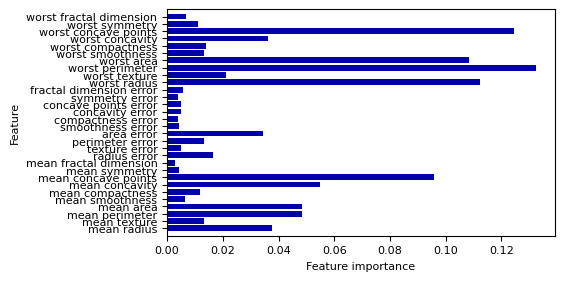

In [18]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

    
X, y = cancer.data, cancer.target
forest = RandomForestClassifier(random_state=0, n_estimators=512, n_jobs=-1)
forest.fit(X,y)
plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(forest)

#### Strengths, weaknesses and parameters
RandomForest are among most widely used algorithms:

* Don't require a lot of tuning
* Typically very accurate models
* Handles heterogeneous features well
* Implictly selects most relevant features

Downsides:

* less interpretable, slower to train (but parallellizable)
* don't work well on high dimensional sparse data (e.g. text)

## Adaptive Boosting (AdaBoost)
* Builds an ensemble of _weighted_ weak learners
    * Typically shallow trees or stumps
* Each base model tries to correct the mistakes of the previous ones
    * Sequential, not parallel (like RandomForest)
    * We give misclassified samples more weight
* Force next model to get these points right by either:
    * Passing on the weight to the loss (e.g. weighted Gini index)
    * Sample data with probability = sample weights
        * Misclassified samples are sampled multiple times so they get a higher weight
* Do weighted vote over all models

## AdaBoost algorithm
* Reset sample weights to $\frac{1}{N}$
* Build a model, using it's own algorithm (e.g. decision stumps with gini index)
* Give it a weight related to its error $E$
$$w_{i} =  \lambda\log(\frac{1-E}{E})$$
    * Good trees get more weight than bad trees 
    * Error is mapped from [0,Inf] to [-1,1], use small minimum error to avoid infinities
    * Learning rate $\lambda$ (shrinkage) decreases impact of individual classifiers
        * Small updates are often better but requires more iterations
* Update the sample weights
    * Increase weight of incorrectly predicted samples:
$s_{n,i+1} = s_{n,i}e^{w_i}$
    * Decrease weight of correctly predicted samples:
$s_{n,i+1} = s_{n,i}e^{-w_i}$
    * Normalize weights to add up to 1
* Sample new points according to $s_{n,i+1}$
* Repeat for $I$ rounds

In [19]:
# Code from https://xavierbourretsicotte.github.io/AdaBoost.html
def AdaBoost_scratch(X,y, M=10, learning_rate = 0.5):
    #Initialization of utility variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [],[],[],[],[]

    #Initialize the sample weights
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    #For m = 1 to M
    for m in range(M):   

        #Fit a classifier
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Misclassifications
        incorrect = (y_predict != y)

        #Estimator error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Boost estimator weights
        estimator_weight =  learning_rate * np.log((1. - estimator_error) / estimator_error)

        #Boost sample weights
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))
        sample_weight *= np.exp(-estimator_weight * np.invert(incorrect * ((sample_weight > 0) | (estimator_weight < 0))))
        sample_weight /= np.linalg.norm(sample_weight)
        
        #Save iteration values
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        
    #Convert to np array for convenience   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predictions
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    #print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list

def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1

    # Get current axis and plot
    if ax is None:
        ax = plt.gca()
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
    # Plot classifier background
    if classifier is not None:
        xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
        
        #Check what methods are available
        if hasattr(classifier, "decision_function"):
            zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        elif hasattr(classifier, "predict_proba"):
            zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
        else:
            zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )

        # reshape result and plot
        Z = zz.reshape(xx.shape)
    
        ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5, levels=[0,0.5,1])
        #ax.contour(xx, yy, Z, 2, cmap='RdBu', levels=[0,0.5,1])


from sklearn.datasets import make_circles
Xa, ya = make_circles(n_samples=400, noise=0.15, factor=0.5, random_state=1)
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

estimator_list, estimator_weight_list, sample_weight_list, estimator_error_list = AdaBoost_scratch(Xa, ya, M=60, learning_rate = 0.9)

@interact
def plot_adaboost(iteration=(0,60,1)):
    if iteration == 0:
        s_weights = (sample_weight_list[0,:] / sample_weight_list[0,:].sum() ) * 40
        plot_decision_boundary(None, Xa, ya, N = 20, scatter_weights =s_weights)
    else:
        s_weights = (sample_weight_list[iteration,:] / sample_weight_list[iteration,:].sum() ) * 40
        plot_decision_boundary(estimator_list[iteration-1], Xa, ya, N = 20, scatter_weights =s_weights ) 
        print("Base model {}, error: {:.2f}, weight: {:.2f}".format(
            iteration,estimator_error_list[iteration-1],estimator_weight_list[iteration-1]))
        

interactive(children=(IntSlider(value=30, description='iteration', max=60), Output()), _dom_classes=('widget-i…

Base model 1, error: 0.35, weight: 0.56


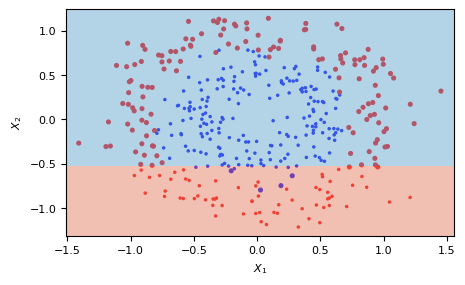

Base model 5, error: 0.21, weight: 1.19


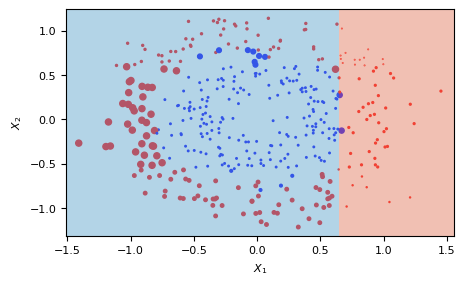

Base model 38, error: 0.35, weight: 0.56


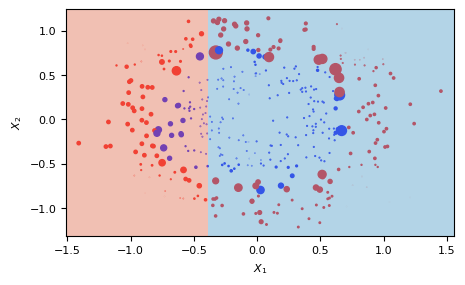

Base model 55, error: 0.31, weight: 0.70


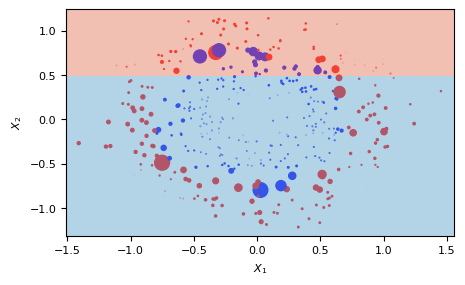

In [20]:
for iteration in [1, 5, 38, 55]:
    plot_adaboost(iteration)
    plt.show()

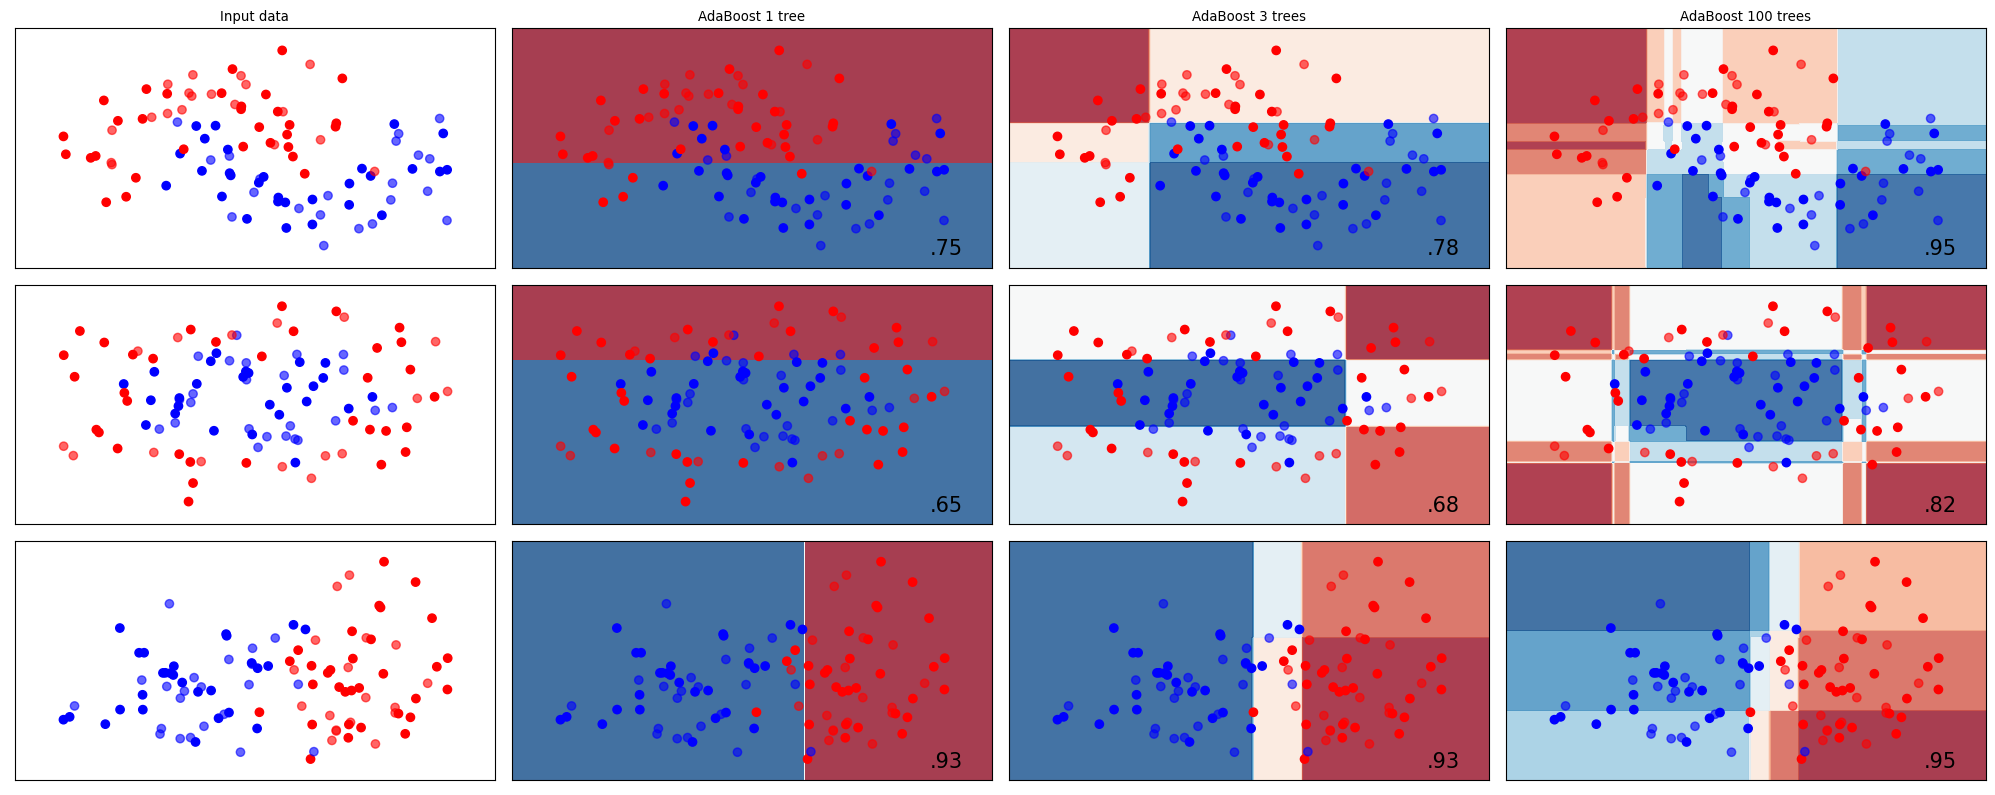

In [21]:
names = ["AdaBoost 1 tree", "AdaBoost 3 trees", "AdaBoost 100 trees"]

classifiers = [
    AdaBoostClassifier(n_estimators=1, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=3, random_state=0, learning_rate=0.5),
    AdaBoostClassifier(n_estimators=100, random_state=0, learning_rate=0.5)
    ]

pc.plot_classifiers(names, classifiers, figuresize=(20,8))  

AdaBoost reduces bias (and a little variance)
* Boosting too much will eventually increase variance

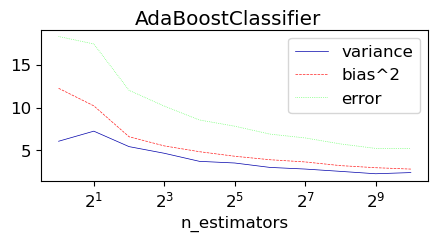

In [22]:
X, y = cancer.data, cancer.target
ab = AdaBoostClassifier(random_state=0, n_estimators=1024)
plot_bias_variance_rf(ab, X, y)

## AdaBoost Recap
* Representation: weighted ensemble of base models
    * Base models can be built by any algorithm
    * Classification: weighted vote over all base models
    * Regression: $$y = \sum_{i=1}^{N} w_i tree_i(X)$$
* Loss function: weighted loss function of base models
* Optimization: Greedy search


## Gradient Boosted Regression Trees (Gradient Boosting Machines)
Several differences to AdaBoost:
* Start with initial guess (e.g. 1 leaf, average value of all samples)
* Base-models are shallow trees (depth 2-4, not stumps)
* Models are weighted (scaled) by same amount (learning rate)
* Subsequent models aim to predict the error of the previous model
    * _Additive model_: final prediction is the sum of all base-model predictions
* Iterate until $I$ trees are built (or error converges)



## GradientBoosting Intuition (Regression)
* Do initial prediction $M_0$ (e.g. average target value)
* Compute the _pseudo-residual_ (error) _for every sample_ $n$: $r_{n} = y_n - y^{(M_{i})}_n$
    * Where $y^{(M_{i})}_n$ is the prediction for $y_n$ by model $M_{i}$


* Build new model $M_1$ to predict the pseudo-residual of $M_0$
* New prediction at step $I$:
$$y_{n} = y^{(M_{i-1})}_n + \lambda * y^{(M_{i})}_n = y^{(M_{0})}_n + \sum_{i=1}^I \lambda * y^{(M_{i})}_n$$
    * $\lambda$ is the learning rate (or _shrinkage_)
    * Taking small steps in right direction reduces variance (but requires more iterations)
* Compute new pseudo-residuals, and repeat
    * Each step, the pseudo-residuals get smaller
* Stop after given number of iterations, or when the residuals don't decrease anymore (early stopping)

## GradientBoosting Algorithm (Regression)

* Dataset of $n$ points $D = \{(x_i,y_i)\}_{i=1}^{n}$ where $y_i$ is a numeric target
* Differentiable loss function $\mathcal{L}(y_i,F(x))$. Typically $\mathcal{L} = \frac{1}{2}(y_i - \hat{y}_i)^2$
    * $\frac{\partial \mathcal{L}}{\partial \hat{y}} = 2 * \frac{1}{2}(y_i - \hat{y}_i) * (-1) = \hat{y}_i - y_i$
* Initialize model with constant output value $F_0(x) = \underset{\gamma}{\operatorname{argmin}}\sum_{i=1}^{n}\mathcal{L}(y_i,\gamma)$
    * Compute $\frac{\partial \mathcal{L}}{\partial \gamma} = 0$. For $\mathcal{L}= \frac{1}{2}(y_i - \hat{y}_i)^2$, $F_0(x)$ is the average of $y_i$
* For m=1..M (e.g. M=100 trees):
    * For i=1..n, compute pseudo-residuals $r_{im} = - \left[ \frac{\partial \mathcal{L}(y_i,F(x_i))}{\partial F(x_i)} \right]_{F(x)=F_{m-1}(x)}$
    * Fit a regression model to $r_{im}$, create terminal regions (a.k.a. leafs) $R_{jm}, j=1..J_m$
    * For each leaf j, optimize output $\gamma_{jm} = \underset{\gamma}{\operatorname{argmin}}\sum_{x_i \in R_{ij}}\mathcal{L}(y_i,F_{m-1}(x_i) + \gamma)$
    * For $\mathcal{L}= \frac{1}{2}(y_i - \hat{y}_i)^2$, the optimum is the mean of all values in the leaf.
    * Update $F_{m}(x) = F_{m-1}(x) + \lambda \sum_{j=1}^{J_m} \gamma_m I(x \in R_{jm}))$





``` python
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)
```

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


``` python
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)
```

In [24]:
# We are overfitting. We can decrease max_depth
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


``` python
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)
```

In [25]:
# or decrease the learning rate (less effect) 
gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train) 

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.965


Gradient boosting machines use much simpler trees
- Hence, tends to completely ignore some of the features

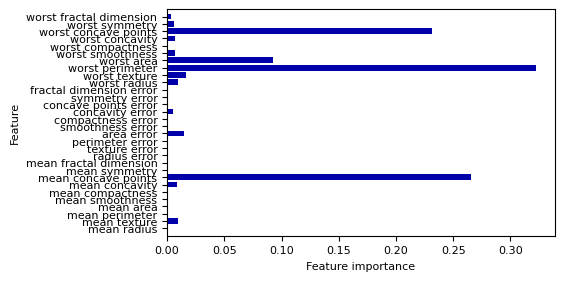

In [26]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plt.rcParams.update({'font.size':8})
plot_feature_importances_cancer(gbrt)

##### Strengths, weaknesses and parameters
* Among the most powerful and widely used models
* Work well on heterogeneous features and different scales
* Require careful tuning, take longer to train.
* Does not work well on high-dimensional sparse data

Main hyperparameters:

* `n_estimators`: Higher is better, but will start to overfit
* `learning_rate`: Lower rates mean more trees are needed to get more complex models
    * Set `n_estimators` as high as possible, then tune `learning_rate`
* `max_depth`: typically kept low (<5), reduce when overfitting
* `n_iter_no_change`: early stopping: algorithm stops if improvement is less than a certain tolerance `tol` for more than `n_iter_no_change` iterations.

### Algorithm overview

| Name | Representation | Loss function | Optimization | Regularization |
|---|---|---|---|---|
| Classification trees | Decision tree | Information Gain (KL div.) / Gini index | Hunt's algorithm | Tree depth,... |
| Regression trees | Decision tree | Min. quadratic distance | Hunt's algorithm | Tree depth,... |
| Bagging | Ensemble of any model | / | / | Number of models,... |
| RandomForest | Ensemble of random trees | / | / | Number of trees,... |
| AdaBoost | Ensemble of models (trees) | Weighted loss of base models | Greedy search | Number of trees,... |
| GradientBoosting | Ensemble of models (trees) | Ensemble loss | Gradient descent | Number of trees,... |

### Summary
- Bagging / RandomForest is a variance-reduction technique
    - Build many high-variance (overfitting) models
        - Typically deep (randomized) decision trees
        - The more different the models, the better
    - Aggregation (soft voting or averaging) reduces variance
    - Parallellizes easily
- Boosting is a bias-reduction technique
    - Build many high-bias (underfitting) models
        - Typically shallow decision trees
        - Sample weights are updated to create different trees
    - Aggregation (soft voting or averaging) reduces bias
    - Doesn't parallelize easily. Slower to train, much faster to predict.
    - Smaller models, typically more accurate than RandomForests.
- You can build ensembles with other models as well
    - Especially if they show high variance or bias
- It is also possible to build _heterogeneous_ ensembles
    - Models from different algorithms
    - Often a meta-classifier is trained on the predictions: Stacking